Images used: Experiment 6.1,  (experiments > 8 folder)  
Contour, Li threshold, edge extraction, tilt left-right tips, no scale of edge images  
Tutorial 2 Notebook uses MobileNet model with initialization parameters input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)  
We'll try different non-default input shape, different keras applications than MobileNet (like VGG16) 

# Tutorial 2: Building a first model

In tutorial 1, we got a basic understanding of our problem. We learned that the images show over 1000 different whales. For the majority of them exists only a single image. 
We also considered the score function that determins the placings on the leaderboard. Recall that our task is:

**For every image *i* in the *test_val* folder, predict the 20 images that are most similar to *i*.**

In this tutorial, we will build two solutions to this problem. Let's get started!

### Table of contents

[1. Similarity between Images](#section1) <br>
[2. A bit of history: The ImageNet Challenge](#section2) <br>
&emsp; [2.1 What is a Deep Learning Model for image classification](#section2.1) <br>
[3. On the shoulders of giants: Using pretrained model to convert images](#section3) <br>
[4. How to measure similarity](#section4) <br>
[5. Our baseline](#section5) <br>
[6. Learn, don't define: A better similarity measure](#section6) <br>
&emsp; [6.1 Examples for the AI: Creating image pairs ](#section6.1) <br>
&emsp; [6.2 Feeding examples to the AI ](#section6.2) <br>
&emsp; [6.3 Defining the model ](#section6.3) <br>
&emsp; [6.4 Training the model ](#section6.4) <br>
&emsp; [6.5 Creating predictions  ](#section6.5) <br>


In [1]:
# For readability, we list all libraries we use in this notebook at the beginning
import sys
sys.path.insert(0, '..')
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
from matplotlib.pyplot import imshow
from pathlib import Path
from itertools import combinations
#from src.data.process_dataset import DataGeneratorFromEmbeddings
from src.src_data_process_dataset import DataGeneratorFromEmbeddings
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras import backend as K
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Dense
from tensorflow.keras.initializers import RandomNormal
import matplotlib.pyplot as plt

# Experiment
from tensorflow.keras.applications import VGG16 # too much time, may not work on laptop
from tensorflow.keras.applications import MobileNetV2

# Baseline model with contours as input

In [2]:
# DEFAULT TUTORIAL 2
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Experiment 11.1: Try with different input image size
#IMG_HEIGHT = 90
#IMG_WIDTH = 460

TRAIN_PATH = '../experiments/8. contour_edge_Li_tilt_noscaling/train/'
TEST_PATH = '../experiments/8. contour_edge_Li_tilt_noscaling/test-val/'
OUT_FILE = '../experiments/8. contour_edge_Li_tilt_noscaling/' + 'cosine_contours_Li_edgeExtraction_tilt_noscale_vgg16.csv'

# DEFAULT TUTORIAL 2
#model = MobileNet(weights='imagenet', include_top=False, pooling='avg', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)) 

# Experiment 11.0: Different keras model
#model = MobileNet(weights='imagenet', include_top=False, pooling='avg', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1))
model = VGG16(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
#https://pixel.facebook.com/notes/ai-viet-nam/t%C3%ACm-%E1%BA%A3nh-t%C6%B0%C6%A1ng-t%E1%BB%B1-d%C3%B9ng-deep-learning-v%E1%BB%9Bi-35-d%C3%B2ng-code-tensorflow/358858454741292/
#https://viblo.asia/p/gioi-thieu-ve-cac-pre-trained-models-trong-linh-vuc-computer-vision-3Q75wB1GlWb

9412608/9406464 [==============================] - 8s 1us/step


In [3]:
train_data_path = Path(TRAIN_PATH)
train_files_paths = list(train_data_path.glob('*/*.jpg'))  # All file paths
train_files_names = [p.name for p in train_files_paths]  # Only the file names without the full path
train_files_classes = [p.parent.name for p in train_files_paths]  # The parent directory, i.e. the whale ID, for each image

test_data_path = Path(TEST_PATH)
test_files_paths = list(test_data_path.glob('*.jpg'))
test_files_names = [p.name for p in test_files_paths]

To load a single picture we have to read the file, convert it into a [tensor](https://www.tensorflow.org/api_docs/python/tf/Tensor) object, adjust the size and standardize it to the MobileNet input format.

In [4]:
BATCH_SIZE = 32

def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])  # Resize image to 224x224 pixels
    img = preprocess_input(img)  # Do additional preprocessing that is required for MobileNet
    return img

Now that we have defined the prerequisites to load a single picture, we can apply it to all of our pictures. We create a dataset from our input data paths and apply the defined function to each entry in the dataset.

The batch size specifies the number of examples we use in one iteration of calcuation. For now you can ignore it. It will become more relevant later.

In [5]:
train_files = tf.data.Dataset.from_tensor_slices(list(map(str, train_files_paths)))  # Convert paths to strings
train_ds = train_files.map(load_image)  # Apply the load_image function to every image
train_ds = train_ds.batch(BATCH_SIZE)  # Set the batch size

test_files = tf.data.Dataset.from_tensor_slices(list(map(str, test_files_paths)))
test_ds = test_files.map(load_image)
test_ds = test_ds.batch(BATCH_SIZE)

To calculate the embeddings we use the Mobilenet. This will take a while, so time to grab a coffe while this is running :) 

In [6]:
%%time
embed_train = model.predict(train_ds)
embed_test = model.predict(test_ds)

#Take so much time with VGG16 model (more than 30 mins, had to terminate)
# Try MobileNetv2

Wall time: 7min 8s


In [7]:
print(f'Shape of training embeddings {embed_train.shape}')
print(f'Shape of test embeddings {embed_test.shape}')

Shape of training embeddings (3956, 7, 7, 1280)
Shape of test embeddings (808, 7, 7, 1280)


For every picture we have now the representation as a vector with a size of 1024. We can calculate the cosine similarity between all of them.

In [11]:
all_names = np.concatenate((train_files_names, test_files_names))  # Combine the train and test data
all_paths = np.concatenate((train_files_paths, test_files_paths))
embed_all = np.concatenate((embed_train, embed_test))
print(f'Shape of all embeddings {embed_all.shape}')

Shape of all embeddings (4764, 1024)


In [34]:
similarity_matrix = cosine_similarity(embed_test, embed_all)
print(f'Shape of the similarity matrix {similarity_matrix.shape}')

Shape of the similarity matrix (808, 4764)


For each of the 808 pictures in the test dataset we have the similarity to each of the 5340 other picutres. Let us take a look at one example.

In [13]:
index_1 = 666
index_2 = 2656
print(f'The cosine similarity of picture {index_1} and {index_2} is {similarity_matrix[index_1, index_2]}')

The cosine similarity of picture 666 and 2656 is 0.6439400911331177


And also at the two respective pictures

In [14]:
def show_images(img_paths):
    plt.figure(figsize=(30, 30))
    image_count = len(img_paths)
    for path, n in zip(img_paths, range(image_count)):
        ax = plt.subplot(image_count, 4, n + 1)
        img = load_img(path)
        plt.imshow(img)
        plt.title(f'{path.name}, class: {path.parent.name}')

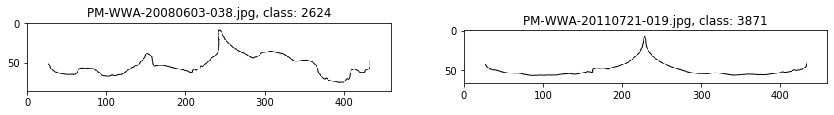

In [15]:
show_images([all_paths[index_1], all_paths[index_2]])

To create a submission, we sort the similarities in descending order and write the twenty most similar pictures in to a file. We use the [np.argsort](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html) function, which will return the indices to sort our matrix column-wise in ascending order. Since we want to have the direction descending, we will put a **-** before the similarity matrix.

In [16]:
indices = np.argsort(-similarity_matrix, axis=1)

Recall that the format for a submissions is

*test_pic, predicted_pic_1, predicted_pic_2, ...., predicted_pic_20*

The cosine similarity between a picture and itself is always 1.0. Hence the most similar image is always the image itself and we can create a submission as follows:

In [17]:
with open(OUT_FILE, 'w') as f:
    for i in range(len(test_files_names)):
        indices_of_top_predictions = indices[i,:21]  # Get the indices of the 21 most similar images
        names_of_top_predictions = all_names[indices_of_top_predictions]  # Get the file names of the 21 most similar images
        preds = ','.join(names_of_top_predictions)  # Put a , between the image names
        f.write(preds + '\n')  # Write it in a new line

When we upload the submission we get a score of *83.00*. 

<font color='blue'>

**Best practice:** 
- Deep Learning models are state-of-the-art for almost every image-type problem
- You can use pretrained models to compress the data in an image
- The cosine is an good baseline for similarity between vectors
- When tackling an AI problem, always start with a simple model. This is called the baseline model

In [15]:
for i in range(len(test_files_names)):
    indices_of_top_predictions = indices[i,:3]  # Get the indices of the 21 most similar images
    names_of_top_predictions = all_names[indices_of_top_predictions]  # Get the file names of the 21 most similar images
    preds = ','.join(names_of_top_predictions)  # Put a , between the image names
    print(preds)

PM-WWA-20170321-046.jpg,PM-WWA-20070502-B046.jpg,PM-WWA-20150329-564.jpg
PM-WWA-20170321-053.jpg,PM-WWA-20060811-086.jpg,PM-WWA-20090811-048.jpg
PM-WWA-20170321-322.jpg,PM-WWA-20080606-011.jpg,PM-WWA-20100410-011.jpg
PM-WWA-20170321-332.jpg,PM-WWA-20140703-129.jpg,PM-WWA-20130714-201.jpg
PM-WWA-20170321-344.jpg,PM-WWA-20090717-491.jpg,PM-WWA-20070515-083.jpg
PM-WWA-20170321-358.jpg,PM-WWA-20110626-173.jpg,PM-WWA-20150726-173.jpg
PM-WWA-20170413-014.jpg,PM-WWA-20080607-317.jpg,PM-WWA-20110420-130.jpg
PM-WWA-20170413-042.jpg,PM-WWA-20080619-018.jpg,PM-WWA-20060716-146.jpg
PM-WWA-20170413-050.jpg,PM-WWA-20150401-070.jpg,PM-WWA-20080806-024.jpg
PM-WWA-20170414-346.jpg,PM-WWA-20090813-127.jpg,PM-WWA-20060612-081.jpg
PM-WWA-20170414-359.jpg,PM-WWA-20090630-025.jpg,PM-WWA-20060710-069.jpg
PM-WWA-20170414-363.jpg,PM-WWA-20170921-119.jpg,PM-WWA-20180811-009.jpg
PM-WWA-20170414-424.jpg,PM-WWA-20170921-351.jpg,PM-WWA-20140506-025.jpg
PM-WWA-20170414-444.jpg,PM-WWA-20101022-049.jpg,PM-WWA-20120904

In [16]:
indices_of_top_predictions = indices[5,:4]
names_of_top_predictions = all_names[indices_of_top_predictions]

In [17]:
names_of_top_predictions

array(['PM-WWA-20170321-358.jpg', 'PM-WWA-20110626-173.jpg',
       'PM-WWA-20150726-173.jpg', 'PM-WWA-20080513-064.jpg'], dtype='<U28')

In [18]:
sample_images = list(indices_of_top_predictions)

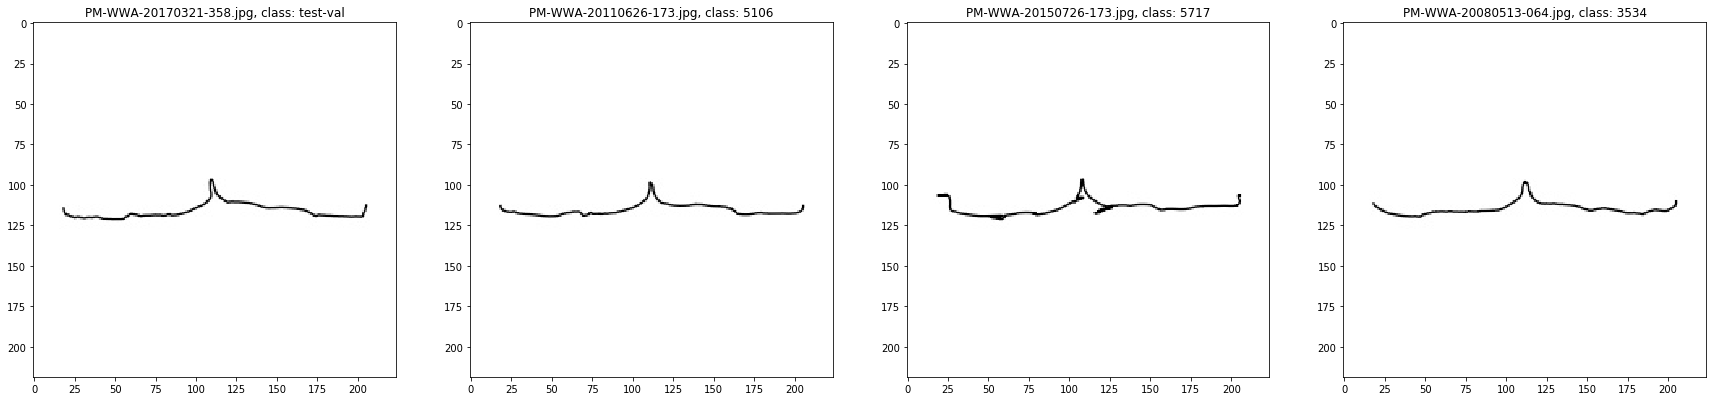

In [19]:
show_images([all_paths[sample_images[0]],all_paths[sample_images[1]],all_paths[sample_images[2]],all_paths[sample_images[3]]])

In [20]:
OUT_FILE

'../experiments/9. contour_edge_Li_tilt_noscaling_larger/cosine_contours_Li_edgeExtraction_tilt_noscale_larger.csv'

# Try different vector similarity measures

All pairwise comparisons: https://scikit-learn.org/stable/modules/metrics.html

## Euclidean

In [43]:
from sklearn.metrics.pairwise import euclidean_distances
euclidean_distance_matrix = euclidean_distances(embed_test, embed_all)
print(f'Shape of the euclidean distance matrix {euclidean_distance_matrix.shape}')

Shape of the euclidean distance matrix (808, 4764)


In [44]:
euclidean_distance_matrix

array([[12.802851, 15.094574, 17.930637, ..., 19.05689 , 16.470211,
        22.964655],
       [17.026535, 20.42269 , 16.409046, ..., 18.562824, 13.380004,
        23.83967 ],
       [16.033783, 18.370129, 19.10646 , ..., 18.597778, 18.968727,
        21.42026 ],
       ...,
       [17.75389 , 18.388248, 17.842815, ...,  0.      , 18.23233 ,
        21.361685],
       [17.41158 , 19.868095, 11.499197, ..., 18.23233 ,  0.      ,
        23.904947],
       [21.276413, 20.231628, 23.599112, ..., 21.361685, 23.904947,
         0.      ]], dtype=float32)

In [45]:
indices_euclidean = np.argsort(euclidean_distance_matrix, axis=1) # we want to sort ascending because this is vector distance

In [46]:
with open(OUT_FILE, 'w') as f:
    for i in range(len(test_files_names)):
        indices_of_top_predictions = indices_euclidean[i,:21]  # Get the indices of the 21 most similar images
        names_of_top_predictions = all_names[indices_of_top_predictions]  # Get the file names of the 21 most similar images
        preds = ','.join(names_of_top_predictions)  # Put a , between the image names
        f.write(preds + '\n')  # Write it in a new line

## Manhattan

In [53]:
from sklearn.metrics.pairwise import manhattan_distances
manhattan_distance_matrix = manhattan_distances(embed_test, embed_all)
print(f'Shape of the Manhattan distance matrix {manhattan_distance_matrix.shape}')

Shape of the Manhattan distance matrix (808, 4764)


In [52]:
indices_manhattan = np.argsort(manhattan_distance_matrix, axis=1) # we want to sort ascending because this is vector distance
with open(OUT_FILE, 'w') as f:
    for i in range(len(test_files_names)):
        indices_of_top_predictions = indices_manhattan[i,:21]  # Get the indices of the 21 most similar images
        names_of_top_predictions = all_names[indices_of_top_predictions]  # Get the file names of the 21 most similar images
        preds = ','.join(names_of_top_predictions)  # Put a , between the image names
        f.write(preds + '\n')  # Write it in a new line